In [30]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-06-17,26328.679688,26769.394531,26174.492188,26510.675781,26510.675781,11090276850
2023-06-18,26510.457031,26675.925781,26325.890625,26336.212891,26336.212891,9565695129
2023-06-19,26335.441406,26984.611328,26312.832031,26851.029297,26851.029297,12826986222


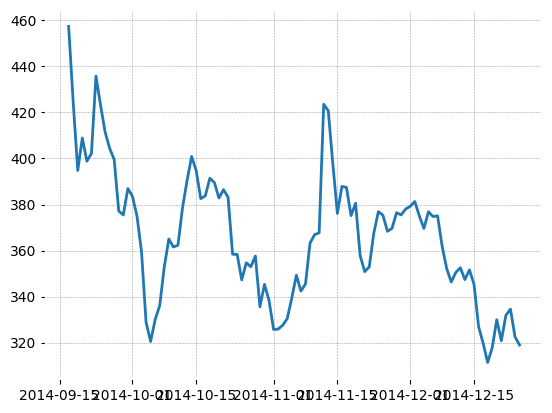

In [22]:
df = data[0:100]
plt.plot(df.index, df.Close)
plt.show()

In [23]:
fig = go.Figure(data=go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'))

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

In [184]:
# Previous and Next data chaining
# df.Low.rolling(5).min()
#df.Low.rolling(5, center=True).min()  # fractal бодохын тулд өмнөх утгуудыг агуулсан хэсгээс бодно

supports = df[df.Low == df.Low.rolling(8, center=True).min()].Low
resistances = df[df.High == df.High.rolling(8, center=True).max()].High
# merge them into one list
levels = pd.concat([supports, resistances])
levels


Date
2014-09-29    372.239990
2014-10-05    289.295990
2014-10-25    342.877014
2014-11-02    320.626007
2014-11-21    344.112000
2014-11-28    358.454987
2014-12-11    338.763000
2014-12-18    304.231995
2014-09-23    441.557007
2014-10-09    382.726013
2014-10-14    411.697998
2014-11-13    457.092987
2014-11-25    394.700989
dtype: float64

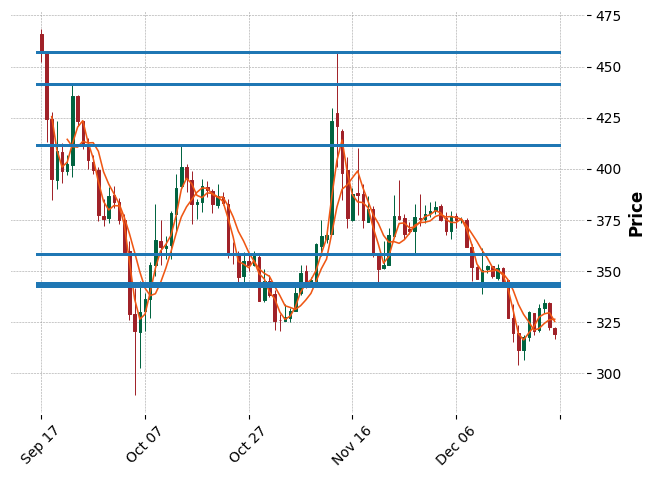

In [185]:
clean_levels = levels[abs(levels.diff() > 10)]
mpf.plot(df, type='candle', hlines=clean_levels.to_list(), style='charles', mav=(3, 6))

In [267]:
# Supports and resistance line connected only between 2 points
support_points = supports.sort_values(ascending=True).head(2)
resistance_points = resistances.sort_values(ascending=True).tail(2)
# resistance_points.index[0]
resistance_points

Date
2014-09-23    441.557007
2014-11-13    457.092987
Name: High, dtype: float64

In [268]:
def slope_line(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    # line_points = coefs[0] * new_x + coefs[1]

    return coefs

In [269]:
supports = df[df.Low == df.Low.rolling(8, center=True).min()].Low
resistances = df[df.High == df.High.rolling(8, center=True).max()].High
slope, intercept = slope_line(resistance_points)
intercept
# x = 2014-12-05.astype('datetime64[s]')
# x = x.set_index('date')
# y = slope * x + intercept
# resistances

441.55700683593744

In [304]:
# LAST High Pointoos hoish 10 unit
filtered = df[(df.index < resistance_points.index[1]) & (df.index > resistance_points.index[0])]
# len(filtered)
x_index = filtered.index
x_values = []
y_values = []
numrange = len(filtered)
top_max = resistance_points.max()
top_min = resistance_points.min()
top_diff = top_max - top_min
diff_step = top_diff/numrange
diff_step

y = top_min
for i in range(0,50):
    y = y + diff_step
    y_values.append(y)
    x_values.append(i)
    # y_value = top_min + diff_step
    # y.append(y_value)
    # x.append(i)
    # point = slope * i + intercept
    # y.append(point)
    # x.append(i)
    # resistance_line = np.polyfit(i, filtered['Close'][i], 1)
    # print("Hello World", filtered['Close'][i], "kkkkk", i)
    # print(point)
    # if point <= 1:
    #     break

resistance_line = np.polyfit(x_values, y_values, 1)
resistance_line
# x_values
# x_index

DatetimeIndex(['2014-09-24', '2014-09-25', '2014-09-26', '2014-09-27',
               '2014-09-28', '2014-09-29', '2014-09-30', '2014-10-01',
               '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05',
               '2014-10-06', '2014-10-07', '2014-10-08', '2014-10-09',
               '2014-10-10', '2014-10-11', '2014-10-12', '2014-10-13',
               '2014-10-14', '2014-10-15', '2014-10-16', '2014-10-17',
               '2014-10-18', '2014-10-19', '2014-10-20', '2014-10-21',
               '2014-10-22', '2014-10-23', '2014-10-24', '2014-10-25',
               '2014-10-26', '2014-10-27', '2014-10-28', '2014-10-29',
               '2014-10-30', '2014-10-31', '2014-11-01', '2014-11-02',
               '2014-11-03', '2014-11-04', '2014-11-05', '2014-11-06',
               '2014-11-07', '2014-11-08', '2014-11-09', '2014-11-10',
               '2014-11-11', '2014-11-12'],
              dtype='datetime64[ns]', name='Date', freq=None)

DatetimeIndex(['2014-09-23', '2014-11-25'], dtype='datetime64[ns]', name='Date', freq=None)

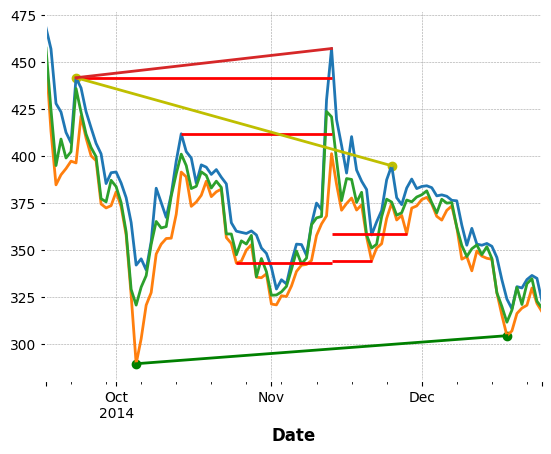

In [303]:
# MATPLOTLIB



clean_levels = levels[abs(levels.diff() > 0)]
first_point = resistances.head(1)
last_point = resistances.tail(1)
top_points = pd.concat([first_point, last_point])

df.High.plot()
df.Low.plot()
df.Close.plot()
plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
plt.plot(x_values,y_values, color="b")
# plt.scatter(resistance_points.index, resistance_points, color='r')
plt.scatter(support_points.index, support_points, color="g")
plt.scatter(top_points.index, top_points, color="y")
plt.plot(top_points.index, top_points, color="y")
plt.plot(resistance_points.index, resistance_points)
plt.plot(support_points.index, support_points, color="g")
top_points.index

In [130]:
# with indicator

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=[450]*len(df), line=dict(color='red', width=2), name="Support and Resistance"),
                                    go.Scatter(x=df.index, y=support_points, line=dict(color='green', width=2), name="Support and Resistance"),
                                    go.Scatter(x=df.index, y=resistances, mode="markers", marker=dict(size=5, color="MediumPurple"), name="Sell"),
                                    go.Scatter(x=df.index, y=supports, mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()